In [22]:
import pandas as pd

In [23]:
df=pd.read_csv('/kaggle/input/new-data-2/new_data_2.csv')

In [24]:
df.head()

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y30,x31,y31,x32,y32,x33,y33,x34,y34,target
0,0.476535,0.366498,0.476804,0.359319,0.475738,0.358378,0.474682,0.357341,0.474839,0.359071,...,0.635365,0.418692,0.608916,0.388385,0.641650,0.000000,0.000000,0.000000,0.000000,1
1,0.474410,0.397083,0.473103,0.391008,0.472416,0.390489,0.472051,0.389991,0.470423,0.391237,...,0.625212,0.437651,0.612700,0.423325,0.628663,0.457407,0.514062,0.580556,0.630729,1
2,0.339507,0.293347,0.332266,0.288797,0.327988,0.289112,0.323918,0.289463,0.344367,0.288060,...,0.651801,0.368331,0.605753,0.404012,0.639864,0.223148,0.311458,0.594444,0.494792,9
3,0.430899,0.387932,0.432586,0.379750,0.430481,0.378213,0.428413,0.376827,0.435235,0.381818,...,0.689175,0.378882,0.650294,0.348221,0.694410,0.434259,0.481771,0.668519,0.597917,6
4,0.490887,0.364345,0.490853,0.355861,0.490024,0.354849,0.489299,0.353818,0.488503,0.356390,...,0.692504,0.439184,0.646042,0.413528,0.692971,0.494444,0.530729,0.704630,0.676042,0


In [25]:
df.columns

Index(['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5',
       'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10', 'y10', 'x11',
       'y11', 'x12', 'y12', 'x13', 'y13', 'x14', 'y14', 'x15', 'y15', 'x16',
       'y16', 'x17', 'y17', 'x18', 'y18', 'x19', 'y19', 'x20', 'y20', 'x21',
       'y21', 'x22', 'y22', 'x23', 'y23', 'x24', 'y24', 'x25', 'y25', 'x26',
       'y26', 'x27', 'y27', 'x28', 'y28', 'x29', 'y29', 'x30', 'y30', 'x31',
       'y31', 'x32', 'y32', 'x33', 'y33', 'x34', 'y34', 'target'],
      dtype='object')

In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import joblib



In [40]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Load the data
df = pd.read_csv('/kaggle/input/new-data-2/new_data_2.csv')
df['target'] = df['target'].astype(int)

# Shuffle the dataset at the dataframe level
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)  # Shuffle and reset index

# Separate features and target
feature_columns = [col for col in df.columns if col != 'target']
X = df[feature_columns].values
y = df['target'].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.save')  # Save the scaler for later use

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed)

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create PyTorch Datasets
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle batches during training
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)    # No shuffle for validation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for testing

# Verify dataset shuffling
print(f"Total training samples: {len(train_dataset)}")
print(f"Total validation samples: {len(val_dataset)}")
print(f"Total test samples: {len(test_dataset)}")


Total training samples: 4976
Total validation samples: 276
Total test samples: 277


In [71]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import joblib

# ---------------------------------------------------
# Data Preparation
# ---------------------------------------------------

# Load the data
df = pd.read_csv('/kaggle/input/new-data-2/new_data_2.csv')
df['target'] = df['target'].astype(int)

# Separate features and target
feature_columns = [col for col in df.columns if col != 'target']
X = df[feature_columns].values
y = df['target'].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.save')  # Save the scaler for later use

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create PyTorch Datasets
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------------------------------
# Model Definition
# ---------------------------------------------------
class MLPWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_hidden_size, output_size, dropout_prob=0.5):
        """
        A neural network combining MLP and LSTM layers with progressive dimensionality reduction.
        Args:
            input_size (int): Number of input features.
            hidden_size (int): Number of units in the first fully connected layer.
            lstm_hidden_size (int): Number of units in the LSTM layer.
            output_size (int): Number of output classes.
            dropout_prob (float): Dropout probability.
        """
        super(MLPWithLSTM, self).__init__()

        # Fully Connected Layers before LSTM
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

        # LSTM Layer
        self.lstm = nn.LSTM(hidden_size // 2, lstm_hidden_size, batch_first=True)

        # Fully Connected Layers after LSTM
        self.fc3 = nn.Linear(lstm_hidden_size, lstm_hidden_size // 2)
        self.fc4 = nn.Linear(lstm_hidden_size // 2, output_size)

    def forward(self, x):
        # Add a sequence dimension for LSTM
        x = x.unsqueeze(1)  # Shape: (batch_size, 1, input_size)

        # Pass through initial FC layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # Shape: (batch_size, 1, lstm_hidden_size)
        lstm_out = lstm_out.squeeze(1)  # Remove the sequence dimension

        # Pass through final FC layers
        x = self.fc3(lstm_out)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# ---------------------------------------------------
# Training and Evaluation Functions
# ---------------------------------------------------

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for features, labels in tqdm(train_loader, desc="Training"):
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * features.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for features, labels in tqdm(val_loader, desc="Validation"):
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * features.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

# ---------------------------------------------------
# Training Loop
# ---------------------------------------------------

# Model parameters
input_size = X_train.shape[1]

hidden_size = 512 # First fully connected layer size
lstm_hidden_size = 64 # LSTM layer hidden size
output_size = 10  # Number of output classes
dropout_prob = 0.3  # Dropout probability

# Initialize the model
model = MLPWithLSTM(input_size, hidden_size, lstm_hidden_size, output_size, dropout_prob)
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
best_val_acc = 0.0
num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'mlp_lstm_model.pth')
        print(f"Model saved with validation accuracy: {val_acc:.4f}")

# ---------------------------------------------------
# Testing
# ---------------------------------------------------

def test_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for features, labels in tqdm(test_loader, desc="Testing"):
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {test_acc:.4f}")

# Load the best model and test
model.load_state_dict(torch.load('mlp_lstm_model.pth'))
test_model(model, test_loader, device)


Validation: 100%|██████████| 26/26 [00:00<00:00, 778.76it/s]


Epoch 1/100
Train Loss: 1.6547, Train Accuracy: 0.4351
Val Loss: 1.0120, Val Accuracy: 0.6767
Model saved with validation accuracy: 0.6767


Validation: 100%|██████████| 26/26 [00:00<00:00, 827.32it/s]


Epoch 2/100
Train Loss: 0.9741, Train Accuracy: 0.6439
Val Loss: 0.7058, Val Accuracy: 0.7274
Model saved with validation accuracy: 0.7274


Validation: 100%|██████████| 26/26 [00:00<00:00, 788.20it/s]


Epoch 3/100
Train Loss: 0.8078, Train Accuracy: 0.6773
Val Loss: 0.6462, Val Accuracy: 0.7370
Model saved with validation accuracy: 0.7370


Validation: 100%|██████████| 26/26 [00:00<00:00, 811.33it/s]


Epoch 4/100
Train Loss: 0.7463, Train Accuracy: 0.7065
Val Loss: 0.6649, Val Accuracy: 0.7250


Validation: 100%|██████████| 26/26 [00:00<00:00, 615.99it/s]


Epoch 5/100
Train Loss: 0.7059, Train Accuracy: 0.7109
Val Loss: 0.5999, Val Accuracy: 0.7467
Model saved with validation accuracy: 0.7467


Validation: 100%|██████████| 26/26 [00:00<00:00, 538.82it/s]


Epoch 6/100
Train Loss: 0.6852, Train Accuracy: 0.7295
Val Loss: 0.5724, Val Accuracy: 0.7467


Validation: 100%|██████████| 26/26 [00:00<00:00, 552.43it/s]


Epoch 7/100
Train Loss: 0.6633, Train Accuracy: 0.7295
Val Loss: 0.5328, Val Accuracy: 0.7648
Model saved with validation accuracy: 0.7648


Validation: 100%|██████████| 26/26 [00:00<00:00, 786.59it/s]


Epoch 8/100
Train Loss: 0.6353, Train Accuracy: 0.7413
Val Loss: 0.5549, Val Accuracy: 0.7648


Validation: 100%|██████████| 26/26 [00:00<00:00, 816.83it/s]


Epoch 9/100
Train Loss: 0.6172, Train Accuracy: 0.7488
Val Loss: 0.5206, Val Accuracy: 0.7684
Model saved with validation accuracy: 0.7684


Validation: 100%|██████████| 26/26 [00:00<00:00, 820.27it/s]


Epoch 10/100
Train Loss: 0.5899, Train Accuracy: 0.7651
Val Loss: 0.5082, Val Accuracy: 0.7793
Model saved with validation accuracy: 0.7793


Validation: 100%|██████████| 26/26 [00:00<00:00, 814.37it/s]


Epoch 11/100
Train Loss: 0.5780, Train Accuracy: 0.7641
Val Loss: 0.5282, Val Accuracy: 0.7793


Validation: 100%|██████████| 26/26 [00:00<00:00, 761.08it/s]


Epoch 12/100
Train Loss: 0.5886, Train Accuracy: 0.7641
Val Loss: 0.5459, Val Accuracy: 0.7877
Model saved with validation accuracy: 0.7877


Validation: 100%|██████████| 26/26 [00:00<00:00, 768.50it/s]


Epoch 13/100
Train Loss: 0.5763, Train Accuracy: 0.7742
Val Loss: 0.5037, Val Accuracy: 0.7841


Validation: 100%|██████████| 26/26 [00:00<00:00, 790.84it/s]


Epoch 14/100
Train Loss: 0.5479, Train Accuracy: 0.7809
Val Loss: 0.5005, Val Accuracy: 0.7829


Validation: 100%|██████████| 26/26 [00:00<00:00, 799.81it/s]


Epoch 15/100
Train Loss: 0.5299, Train Accuracy: 0.7922
Val Loss: 0.5212, Val Accuracy: 0.7732


Validation: 100%|██████████| 26/26 [00:00<00:00, 792.51it/s]


Epoch 16/100
Train Loss: 0.5293, Train Accuracy: 0.7904
Val Loss: 0.4794, Val Accuracy: 0.8070
Model saved with validation accuracy: 0.8070


Validation: 100%|██████████| 26/26 [00:00<00:00, 765.08it/s]


Epoch 17/100
Train Loss: 0.5136, Train Accuracy: 0.7917
Val Loss: 0.4616, Val Accuracy: 0.8106
Model saved with validation accuracy: 0.8106


Validation: 100%|██████████| 26/26 [00:00<00:00, 775.88it/s]


Epoch 18/100
Train Loss: 0.5011, Train Accuracy: 0.7990
Val Loss: 0.5016, Val Accuracy: 0.8046


Validation: 100%|██████████| 26/26 [00:00<00:00, 780.57it/s]


Epoch 19/100
Train Loss: 0.4724, Train Accuracy: 0.8111
Val Loss: 0.4922, Val Accuracy: 0.7949


Validation: 100%|██████████| 26/26 [00:00<00:00, 804.70it/s]


Epoch 20/100
Train Loss: 0.4809, Train Accuracy: 0.8049
Val Loss: 0.4730, Val Accuracy: 0.7901


Validation: 100%|██████████| 26/26 [00:00<00:00, 791.46it/s]


Epoch 21/100
Train Loss: 0.4813, Train Accuracy: 0.8121
Val Loss: 0.4697, Val Accuracy: 0.7889


Validation: 100%|██████████| 26/26 [00:00<00:00, 815.93it/s]


Epoch 22/100
Train Loss: 0.4989, Train Accuracy: 0.8008
Val Loss: 0.4402, Val Accuracy: 0.8034


Validation: 100%|██████████| 26/26 [00:00<00:00, 745.40it/s]


Epoch 23/100
Train Loss: 0.4525, Train Accuracy: 0.8217
Val Loss: 0.4481, Val Accuracy: 0.7998


Validation: 100%|██████████| 26/26 [00:00<00:00, 752.43it/s]


Epoch 24/100
Train Loss: 0.4547, Train Accuracy: 0.8230
Val Loss: 0.4379, Val Accuracy: 0.8142
Model saved with validation accuracy: 0.8142


Validation: 100%|██████████| 26/26 [00:00<00:00, 819.56it/s]


Epoch 25/100
Train Loss: 0.4477, Train Accuracy: 0.8256
Val Loss: 0.4417, Val Accuracy: 0.8239
Model saved with validation accuracy: 0.8239


Validation: 100%|██████████| 26/26 [00:00<00:00, 770.68it/s]


Epoch 26/100
Train Loss: 0.4342, Train Accuracy: 0.8302
Val Loss: 0.4235, Val Accuracy: 0.8215


Validation: 100%|██████████| 26/26 [00:00<00:00, 812.54it/s]


Epoch 27/100
Train Loss: 0.4415, Train Accuracy: 0.8302
Val Loss: 0.4365, Val Accuracy: 0.8251
Model saved with validation accuracy: 0.8251


Validation: 100%|██████████| 26/26 [00:00<00:00, 814.76it/s]


Epoch 28/100
Train Loss: 0.4306, Train Accuracy: 0.8393
Val Loss: 0.4241, Val Accuracy: 0.8408
Model saved with validation accuracy: 0.8408


Validation: 100%|██████████| 26/26 [00:00<00:00, 819.48it/s]


Epoch 29/100
Train Loss: 0.4100, Train Accuracy: 0.8367
Val Loss: 0.4160, Val Accuracy: 0.8432
Model saved with validation accuracy: 0.8432


Validation: 100%|██████████| 26/26 [00:00<00:00, 823.19it/s]


Epoch 30/100
Train Loss: 0.4183, Train Accuracy: 0.8364
Val Loss: 0.4457, Val Accuracy: 0.8203


Validation: 100%|██████████| 26/26 [00:00<00:00, 779.61it/s]


Epoch 31/100
Train Loss: 0.4322, Train Accuracy: 0.8318
Val Loss: 0.4215, Val Accuracy: 0.8432


Validation: 100%|██████████| 26/26 [00:00<00:00, 803.16it/s]


Epoch 32/100
Train Loss: 0.4072, Train Accuracy: 0.8424
Val Loss: 0.4056, Val Accuracy: 0.8468
Model saved with validation accuracy: 0.8468


Validation: 100%|██████████| 26/26 [00:00<00:00, 800.74it/s]


Epoch 33/100
Train Loss: 0.4041, Train Accuracy: 0.8406
Val Loss: 0.4110, Val Accuracy: 0.8179


Validation: 100%|██████████| 26/26 [00:00<00:00, 811.02it/s]


Epoch 34/100
Train Loss: 0.3916, Train Accuracy: 0.8566
Val Loss: 0.4179, Val Accuracy: 0.8456


Validation: 100%|██████████| 26/26 [00:00<00:00, 797.03it/s]


Epoch 35/100
Train Loss: 0.3818, Train Accuracy: 0.8587
Val Loss: 0.4169, Val Accuracy: 0.8456


Validation: 100%|██████████| 26/26 [00:00<00:00, 801.52it/s]


Epoch 36/100
Train Loss: 0.3712, Train Accuracy: 0.8574
Val Loss: 0.4352, Val Accuracy: 0.8311


Validation: 100%|██████████| 26/26 [00:00<00:00, 721.84it/s]


Epoch 37/100
Train Loss: 0.3714, Train Accuracy: 0.8543
Val Loss: 0.3927, Val Accuracy: 0.8396


Validation: 100%|██████████| 26/26 [00:00<00:00, 787.46it/s]


Epoch 38/100
Train Loss: 0.3724, Train Accuracy: 0.8641
Val Loss: 0.4001, Val Accuracy: 0.8456


Validation: 100%|██████████| 26/26 [00:00<00:00, 728.05it/s]


Epoch 39/100
Train Loss: 0.3757, Train Accuracy: 0.8563
Val Loss: 0.3932, Val Accuracy: 0.8347


Validation: 100%|██████████| 26/26 [00:00<00:00, 740.41it/s]


Epoch 40/100
Train Loss: 0.3748, Train Accuracy: 0.8563
Val Loss: 0.3960, Val Accuracy: 0.8528
Model saved with validation accuracy: 0.8528


Validation: 100%|██████████| 26/26 [00:00<00:00, 791.53it/s]


Epoch 41/100
Train Loss: 0.3685, Train Accuracy: 0.8630
Val Loss: 0.3901, Val Accuracy: 0.8565
Model saved with validation accuracy: 0.8565


Validation: 100%|██████████| 26/26 [00:00<00:00, 834.94it/s]


Epoch 42/100
Train Loss: 0.3498, Train Accuracy: 0.8664
Val Loss: 0.4040, Val Accuracy: 0.8504


Validation: 100%|██████████| 26/26 [00:00<00:00, 804.66it/s]


Epoch 43/100
Train Loss: 0.3720, Train Accuracy: 0.8587
Val Loss: 0.4065, Val Accuracy: 0.8432


Validation: 100%|██████████| 26/26 [00:00<00:00, 839.58it/s]


Epoch 44/100
Train Loss: 0.3539, Train Accuracy: 0.8664
Val Loss: 0.4402, Val Accuracy: 0.8432


Validation: 100%|██████████| 26/26 [00:00<00:00, 807.22it/s]


Epoch 45/100
Train Loss: 0.3368, Train Accuracy: 0.8806
Val Loss: 0.3900, Val Accuracy: 0.8480


Validation: 100%|██████████| 26/26 [00:00<00:00, 823.55it/s]


Epoch 46/100
Train Loss: 0.3692, Train Accuracy: 0.8682
Val Loss: 0.3850, Val Accuracy: 0.8480


Validation: 100%|██████████| 26/26 [00:00<00:00, 768.04it/s]


Epoch 47/100
Train Loss: 0.3261, Train Accuracy: 0.8775
Val Loss: 0.3995, Val Accuracy: 0.8480


Validation: 100%|██████████| 26/26 [00:00<00:00, 807.76it/s]


Epoch 48/100
Train Loss: 0.3207, Train Accuracy: 0.8827
Val Loss: 0.4301, Val Accuracy: 0.8468


Validation: 100%|██████████| 26/26 [00:00<00:00, 777.79it/s]


Epoch 49/100
Train Loss: 0.3279, Train Accuracy: 0.8804
Val Loss: 0.4406, Val Accuracy: 0.8456


Validation: 100%|██████████| 26/26 [00:00<00:00, 827.07it/s]


Epoch 50/100
Train Loss: 0.3148, Train Accuracy: 0.8788
Val Loss: 0.4033, Val Accuracy: 0.8589
Model saved with validation accuracy: 0.8589


Validation: 100%|██████████| 26/26 [00:00<00:00, 787.98it/s]


Epoch 51/100
Train Loss: 0.3195, Train Accuracy: 0.8822
Val Loss: 0.4122, Val Accuracy: 0.8504


Validation: 100%|██████████| 26/26 [00:00<00:00, 711.38it/s]


Epoch 52/100
Train Loss: 0.3291, Train Accuracy: 0.8778
Val Loss: 0.3977, Val Accuracy: 0.8480


Validation: 100%|██████████| 26/26 [00:00<00:00, 721.92it/s]


Epoch 53/100
Train Loss: 0.3254, Train Accuracy: 0.8824
Val Loss: 0.4198, Val Accuracy: 0.8492


Validation: 100%|██████████| 26/26 [00:00<00:00, 735.99it/s]


Epoch 54/100
Train Loss: 0.3018, Train Accuracy: 0.8879
Val Loss: 0.4266, Val Accuracy: 0.8408


Validation: 100%|██████████| 26/26 [00:00<00:00, 732.93it/s]


Epoch 55/100
Train Loss: 0.3122, Train Accuracy: 0.8819
Val Loss: 0.3968, Val Accuracy: 0.8480


Validation: 100%|██████████| 26/26 [00:00<00:00, 799.46it/s]


Epoch 56/100
Train Loss: 0.3024, Train Accuracy: 0.8863
Val Loss: 0.3679, Val Accuracy: 0.8565


Validation: 100%|██████████| 26/26 [00:00<00:00, 736.67it/s]


Epoch 57/100
Train Loss: 0.3088, Train Accuracy: 0.8884
Val Loss: 0.3883, Val Accuracy: 0.8601
Model saved with validation accuracy: 0.8601


Validation: 100%|██████████| 26/26 [00:00<00:00, 808.67it/s]


Epoch 58/100
Train Loss: 0.3035, Train Accuracy: 0.8853
Val Loss: 0.4016, Val Accuracy: 0.8444


Validation: 100%|██████████| 26/26 [00:00<00:00, 800.63it/s]


Epoch 59/100
Train Loss: 0.3094, Train Accuracy: 0.8835
Val Loss: 0.4313, Val Accuracy: 0.8625
Model saved with validation accuracy: 0.8625


Validation: 100%|██████████| 26/26 [00:00<00:00, 825.68it/s]


Epoch 60/100
Train Loss: 0.3076, Train Accuracy: 0.8866
Val Loss: 0.3878, Val Accuracy: 0.8504


Validation: 100%|██████████| 26/26 [00:00<00:00, 721.44it/s]


Epoch 61/100
Train Loss: 0.3067, Train Accuracy: 0.8899
Val Loss: 0.3862, Val Accuracy: 0.8589


Validation: 100%|██████████| 26/26 [00:00<00:00, 805.92it/s]


Epoch 62/100
Train Loss: 0.2701, Train Accuracy: 0.8974
Val Loss: 0.3804, Val Accuracy: 0.8661
Model saved with validation accuracy: 0.8661


Validation: 100%|██████████| 26/26 [00:00<00:00, 795.88it/s]


Epoch 63/100
Train Loss: 0.2798, Train Accuracy: 0.8948
Val Loss: 0.4040, Val Accuracy: 0.8540


Validation: 100%|██████████| 26/26 [00:00<00:00, 834.44it/s]


Epoch 64/100
Train Loss: 0.2745, Train Accuracy: 0.9034
Val Loss: 0.3896, Val Accuracy: 0.8565


Validation: 100%|██████████| 26/26 [00:00<00:00, 831.28it/s]


Epoch 65/100
Train Loss: 0.2721, Train Accuracy: 0.9018
Val Loss: 0.4014, Val Accuracy: 0.8649


Validation: 100%|██████████| 26/26 [00:00<00:00, 805.03it/s]


Epoch 66/100
Train Loss: 0.2774, Train Accuracy: 0.8953
Val Loss: 0.3850, Val Accuracy: 0.8721
Model saved with validation accuracy: 0.8721


Validation: 100%|██████████| 26/26 [00:00<00:00, 786.12it/s]


Epoch 67/100
Train Loss: 0.2762, Train Accuracy: 0.9016
Val Loss: 0.3849, Val Accuracy: 0.8565


Validation: 100%|██████████| 26/26 [00:00<00:00, 775.93it/s]


Epoch 68/100
Train Loss: 0.2641, Train Accuracy: 0.9026
Val Loss: 0.3936, Val Accuracy: 0.8577


Validation: 100%|██████████| 26/26 [00:00<00:00, 751.98it/s]


Epoch 69/100
Train Loss: 0.2868, Train Accuracy: 0.8912
Val Loss: 0.4313, Val Accuracy: 0.8565


Validation: 100%|██████████| 26/26 [00:00<00:00, 714.65it/s]


Epoch 70/100
Train Loss: 0.2565, Train Accuracy: 0.8974
Val Loss: 0.4091, Val Accuracy: 0.8673


Validation: 100%|██████████| 26/26 [00:00<00:00, 792.91it/s]


Epoch 71/100
Train Loss: 0.2611, Train Accuracy: 0.8997
Val Loss: 0.3860, Val Accuracy: 0.8613


Validation: 100%|██████████| 26/26 [00:00<00:00, 802.89it/s]


Epoch 72/100
Train Loss: 0.2776, Train Accuracy: 0.8984
Val Loss: 0.4107, Val Accuracy: 0.8625


Validation: 100%|██████████| 26/26 [00:00<00:00, 801.69it/s]


Epoch 73/100
Train Loss: 0.2483, Train Accuracy: 0.9026
Val Loss: 0.3907, Val Accuracy: 0.8673


Validation: 100%|██████████| 26/26 [00:00<00:00, 806.69it/s]


Epoch 74/100
Train Loss: 0.2665, Train Accuracy: 0.9044
Val Loss: 0.4181, Val Accuracy: 0.8540


Validation: 100%|██████████| 26/26 [00:00<00:00, 817.90it/s]


Epoch 75/100
Train Loss: 0.2545, Train Accuracy: 0.9016
Val Loss: 0.3935, Val Accuracy: 0.8565


Validation: 100%|██████████| 26/26 [00:00<00:00, 791.19it/s]


Epoch 76/100
Train Loss: 0.2826, Train Accuracy: 0.9000
Val Loss: 0.3695, Val Accuracy: 0.8733
Model saved with validation accuracy: 0.8733


Validation: 100%|██████████| 26/26 [00:00<00:00, 809.22it/s]


Epoch 77/100
Train Loss: 0.2498, Train Accuracy: 0.9059
Val Loss: 0.3715, Val Accuracy: 0.8673


Validation: 100%|██████████| 26/26 [00:00<00:00, 771.40it/s]


Epoch 78/100
Train Loss: 0.2630, Train Accuracy: 0.8990
Val Loss: 0.3817, Val Accuracy: 0.8649


Validation: 100%|██████████| 26/26 [00:00<00:00, 745.64it/s]


Epoch 79/100
Train Loss: 0.2490, Train Accuracy: 0.9065
Val Loss: 0.3646, Val Accuracy: 0.8697


Validation: 100%|██████████| 26/26 [00:00<00:00, 739.10it/s]


Epoch 80/100
Train Loss: 0.2478, Train Accuracy: 0.9106
Val Loss: 0.3722, Val Accuracy: 0.8685


Validation: 100%|██████████| 26/26 [00:00<00:00, 793.95it/s]


Epoch 81/100
Train Loss: 0.2524, Train Accuracy: 0.9101
Val Loss: 0.3995, Val Accuracy: 0.8673


Validation: 100%|██████████| 26/26 [00:00<00:00, 788.75it/s]


Epoch 82/100
Train Loss: 0.2775, Train Accuracy: 0.8984
Val Loss: 0.3769, Val Accuracy: 0.8782
Model saved with validation accuracy: 0.8782


Validation: 100%|██████████| 26/26 [00:00<00:00, 822.68it/s]


Epoch 83/100
Train Loss: 0.2340, Train Accuracy: 0.9098
Val Loss: 0.3623, Val Accuracy: 0.8697


Validation: 100%|██████████| 26/26 [00:00<00:00, 770.23it/s]


Epoch 84/100
Train Loss: 0.2448, Train Accuracy: 0.9093
Val Loss: 0.4254, Val Accuracy: 0.8685


Validation: 100%|██████████| 26/26 [00:00<00:00, 783.24it/s]


Epoch 85/100
Train Loss: 0.2665, Train Accuracy: 0.9034
Val Loss: 0.4387, Val Accuracy: 0.8577


Validation: 100%|██████████| 26/26 [00:00<00:00, 697.81it/s]


Epoch 86/100
Train Loss: 0.2378, Train Accuracy: 0.9127
Val Loss: 0.3872, Val Accuracy: 0.8589


Validation: 100%|██████████| 26/26 [00:00<00:00, 779.49it/s]


Epoch 87/100
Train Loss: 0.2355, Train Accuracy: 0.9057
Val Loss: 0.4069, Val Accuracy: 0.8613


Validation: 100%|██████████| 26/26 [00:00<00:00, 779.31it/s]


Epoch 88/100
Train Loss: 0.2466, Train Accuracy: 0.9080
Val Loss: 0.3688, Val Accuracy: 0.8770


Validation: 100%|██████████| 26/26 [00:00<00:00, 808.38it/s]


Epoch 89/100
Train Loss: 0.2416, Train Accuracy: 0.9124
Val Loss: 0.4054, Val Accuracy: 0.8577


Validation: 100%|██████████| 26/26 [00:00<00:00, 796.46it/s]


Epoch 90/100
Train Loss: 0.2629, Train Accuracy: 0.9044
Val Loss: 0.4039, Val Accuracy: 0.8552


Validation: 100%|██████████| 26/26 [00:00<00:00, 773.49it/s]


Epoch 91/100
Train Loss: 0.2335, Train Accuracy: 0.9171
Val Loss: 0.3795, Val Accuracy: 0.8697


Validation: 100%|██████████| 26/26 [00:00<00:00, 541.49it/s]


Epoch 92/100
Train Loss: 0.2343, Train Accuracy: 0.9137
Val Loss: 0.4327, Val Accuracy: 0.8685


Validation: 100%|██████████| 26/26 [00:00<00:00, 826.84it/s]


Epoch 93/100
Train Loss: 0.2313, Train Accuracy: 0.9150
Val Loss: 0.3692, Val Accuracy: 0.8709


Validation: 100%|██████████| 26/26 [00:00<00:00, 768.83it/s]


Epoch 94/100
Train Loss: 0.2463, Train Accuracy: 0.9090
Val Loss: 0.4054, Val Accuracy: 0.8637


Validation: 100%|██████████| 26/26 [00:00<00:00, 791.58it/s]


Epoch 95/100
Train Loss: 0.2095, Train Accuracy: 0.9212
Val Loss: 0.3665, Val Accuracy: 0.8830
Model saved with validation accuracy: 0.8830


Validation: 100%|██████████| 26/26 [00:00<00:00, 805.34it/s]


Epoch 96/100
Train Loss: 0.2304, Train Accuracy: 0.9121
Val Loss: 0.3914, Val Accuracy: 0.8782


Validation: 100%|██████████| 26/26 [00:00<00:00, 760.90it/s]


Epoch 97/100
Train Loss: 0.2259, Train Accuracy: 0.9129
Val Loss: 0.3652, Val Accuracy: 0.8758


Validation: 100%|██████████| 26/26 [00:00<00:00, 806.39it/s]


Epoch 98/100
Train Loss: 0.2323, Train Accuracy: 0.9140
Val Loss: 0.3797, Val Accuracy: 0.8637


Validation: 100%|██████████| 26/26 [00:00<00:00, 770.66it/s]


Epoch 99/100
Train Loss: 0.2350, Train Accuracy: 0.9121
Val Loss: 0.3907, Val Accuracy: 0.8782


Validation: 100%|██████████| 26/26 [00:00<00:00, 821.16it/s]
/tmp/ipykernel_30/3805570151.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Epoch 100/100
Train Loss: 0.2344, Train Accuracy: 0.9134
Val Loss: 0.4330, Val Accuracy: 0.8625


Testing: 100%|██████████| 26/26 [00:00<00:00, 787.00it/s]

Test Accuracy: 0.8880


In [72]:
def test_and_save_predictions(test_df, model, model_path='mlp_lstm_model.pth', scaler_path='scaler.save'):
    """
    Tests the trained model on given test data, saves predictions to a CSV file,
    and visualizes predictions over frame numbers.

    Args:
        test_df (pd.DataFrame): Test data containing features and frame numbers.
        model (nn.Module): The trained model.
        model_path (str): Path to the trained model file.
        scaler_path (str): Path to the saved scaler file.
    """
    # Load the scaler
    scaler = joblib.load(scaler_path)

    # Features and frame numbers
    feature_columns = [col for col in test_df.columns if col != 'frame_number']
    features = test_df[feature_columns].values
    frame_numbers = test_df['frame_number'].values

    # Normalize features
    features = scaler.transform(features)

    # Convert to tensor
    features_tensor = torch.tensor(features, dtype=torch.float32)

    # Load the trained model
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    features_tensor = features_tensor.to(device)

    # Make predictions
    all_predictions = []
    with torch.no_grad():
        outputs = model(features_tensor)  # Shape: (num_samples, output_size)
        _, predicted = torch.max(outputs, 1)  # Predicted class for each row
        all_predictions = predicted.cpu().numpy()

    # Create a DataFrame with frame numbers and predictions
    predictions_df = pd.DataFrame({
        'frame_number': frame_numbers,
        'predicted_class': all_predictions
    })

    # Save predictions to a CSV file
    predictions_df.to_csv('predictions1.csv', index=False)
    print("Predictions saved to 'predictions.csv'")

    return predictions_df


In [73]:
def visualize_predictions(predictions_df):
    """
    Visualizes predictions over frame numbers.

    Args:
        predictions_df (pd.DataFrame): DataFrame containing 'frame_number' and 'predicted_class'.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(predictions_df['frame_number'], predictions_df['predicted_class'], marker='o', linestyle='-')
    plt.title('Predicted Class over Frame Numbers')
    plt.xlabel('Frame Number')
    plt.ylabel('Predicted Class')
    plt.grid(True)
    plt.xticks(predictions_df['frame_number'][::max(1, len(predictions_df) // 20)], rotation=45)
    plt.yticks(range(predictions_df['predicted_class'].min(), predictions_df['predicted_class'].max() + 1))
    plt.show()


In [74]:
# Load test data
test_df = pd.read_csv('/kaggle/input/data-test/data_test.csv')  # Replace with your test data file
test_df['frame_number'] = range(1, len(test_df) + 1)  # Add frame numbers if not present

# Initialize and test the model
model = MLPWithLSTM(input_size, hidden_size, lstm_hidden_size, output_size, dropout_prob)
predictions_df1 = test_and_save_predictions(test_df, model)


/tmp/ipykernel_30/2709850504.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


Predictions saved to 'predictions.csv'


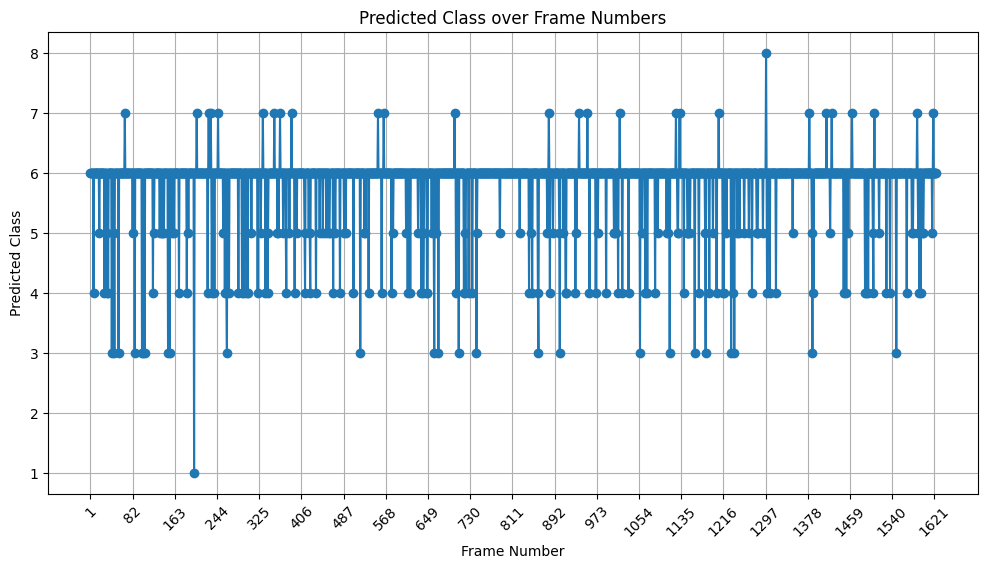

In [75]:
visualize_predictions(predictions_df1)


In [76]:
import torch
import numpy as np
import joblib
'''
This is example 
One thing to be noted . Here i refer to input array of 70 values(features) as sequence. so it is the same input as for mlp in previous version
'''
def load_model_and_scaler():
    # Load the scaler
    scaler = joblib.load('scaler.save')
    input_size = 70  # coordinates for skeleton and club
    hidden_size = 128  
    num_layers = 1
    fc_hidden_sizes = [1024,512,256,128] # fc layers
    output_size = 10  # Number of postures like from p1 to p10

    # sequential model
    model = BiLSTMModel(input_size, hidden_size, num_layers, output_size, fc_hidden_sizes=fc_hidden_sizes)
    model.load_state_dict(torch.load('bilstm_pose_model.pth', map_location=torch.device('cpu')))
    model.eval()

    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    return model, scaler, device

'''
i generated Random sequence which exactly matches how the input from skeleton and club coordinates will go into model 
Real-time inference function for random sequence. This is example 
'''
def predict_with_random_sequence(model, scaler, device):
    # just example random input from skeleton and club coordinates . just like previous mlp model nothing . s
    sequence = np.random.uniform(-1, 1, 70).tolist() # 70 coordinates , 
    # Scale the sequence/input array 
    scaled_sequence = scaler.transform([sequence])  # Scale the incoming sequence

    # Convert to tensor
    sequence_tensor = torch.tensor(scaled_sequence, dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, seq_length, input_size)

    # Sequence length (1 for real-time inference)
    seq_lengths = torch.tensor([1], dtype=torch.long)  # Keep on CPU

    # Make prediction
    with torch.no_grad():
        outputs = model(sequence_tensor, seq_lengths)  # outputs: (1, seq_length, output_size)
        _, predicted = torch.max(outputs.data, 2)  # Get predicted class indices
        predicted_class = predicted.squeeze(0).cpu().item()  # Convert to scalar

    print(f"Predicted Class: {predicted_class}")

# Run the random sequence inference
def run_random_sequence_inference():
    model, scaler, device = load_model_and_scaler()
    
    print("Model loaded. Generating predictions for random sequences...")

    while True:
        # Generate and predict on a random sequence
        predict_with_random_sequence(model, scaler, device)


# Run the random sequence inference loop
run_random_sequence_inference()


NameError: name 'BiLSTMModel' is not defined

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SVMSMOTE
from collections import Counter
import joblib

# Load and preprocess data
df = pd.read_csv('/kaggle/input/new-data-2/new_data_2.csv')  # Replace with the path to your data file

# Separate features and target
X = df.drop(columns=['target']).values.astype(np.float32)
y = df['target'].values

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.save')  # Save scaler for later use

# Check current class distribution
class_counts = Counter(y)
print("Original class distribution:", class_counts)

# Define target class counts to increase size by 30%
sampling_strategy = {cls: int(count * 1.3) for cls, count in class_counts.items()}
print("Target class distribution with 30% increase:", sampling_strategy)

# Apply SVMSMOTE to generate synthetic data
svm_smote = SVMSMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_synthetic, y_synthetic = svm_smote.fit_resample(X, y)

# Combine original and synthetic data
X_augmented = np.vstack([X, X_synthetic])
y_augmented = np.concatenate([y, y_synthetic])

# Split augmented data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Create custom Dataset
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader for train and test sets
train_dataset = SimpleDataset(X_train, y_train)
test_dataset = SimpleDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Define the MLP Model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, dropout_rate=0.3):
        super(MLPModel, self).__init__()
        layers = []
        in_features = input_size
        
        # Add hidden layers with ReLU and dropout
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_features = hidden_size
        
        # Output layer with the number of classes (output_size)
        layers.append(nn.Linear(in_features, output_size))
        
        # Define the entire network
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Model parameters
input_size = X_train.shape[1]
hidden_layers = [1024, 512, 256, 128, 64]
output_size = len(np.unique(y))  # Number of classes
dropout_rate = 0.3

# Instantiate the model, loss function, and optimizer
model = MLPModel(input_size, hidden_layers, output_size, dropout_rate)
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Collect predictions for accuracy
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch.numpy())
        
        # Calculate accuracy and print metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

# Save the model
torch.save(model.state_dict(), 'mlp_model.pth')

# Train and evaluate
train_model(model, train_loader, criterion, optimizer, num_epochs=20)
evaluate_model(model, test_loader)

# ---------------------------------------------------
# Testing Function
# ---------------------------------------------------

def test_model(test_df, model, scaler):
    """
    Test the trained model on new data and output predictions with frame numbers.

    Parameters:
    test_df (pd.DataFrame): The test DataFrame containing features and 'frame_number'.
    model (nn.Module): The trained MLP model.
    scaler (StandardScaler): Scaler used during training to normalize data.
    """
    model.eval()
    
    # Features are from 'x0' to 'x34'; exclude 'frame_number'
    feature_columns = [col for col in test_df.columns if col != 'frame_number']
    
    # Scale the features
    test_df_scaled = test_df.copy()
    test_df_scaled[feature_columns] = scaler.transform(test_df[feature_columns])

    # Extract features and frame numbers
    features = test_df_scaled[feature_columns].values.astype(np.float32)
    frame_numbers = test_df_scaled['frame_number'].values

    # Convert features to tensor
    test_sequences = torch.tensor(features, dtype=torch.float32)

    # Make predictions
    all_predictions = []
    with torch.no_grad():
        outputs = model(test_sequences)
        _, predicted = torch.max(outputs, 1)  # Get the predicted classes
        all_predictions = predicted.numpy()

    # Create a DataFrame with frame numbers and predicted classes
    predictions_df = pd.DataFrame({
        'frame_number': frame_numbers,
        'predicted_class': all_predictions
    })

    # Save predictions to CSV
    predictions_df.to_csv('predictions.csv', index=False)
    print("Predictions saved to 'predictions.csv'")

# Example usage:
test_df = pd.read_csv('/kaggle/input/data-test/data_test.csv')  # Replace with your test data file path
test_model(test_df, model, scaler)